In [1]:
import pandas as pd
import numpy as np
import datetime
 
import seaborn as sns
import matplotlib.pyplot as plt
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
ss = pd.read_csv('/content/SampleSubmission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


### Checking for features that correlate with the target variable

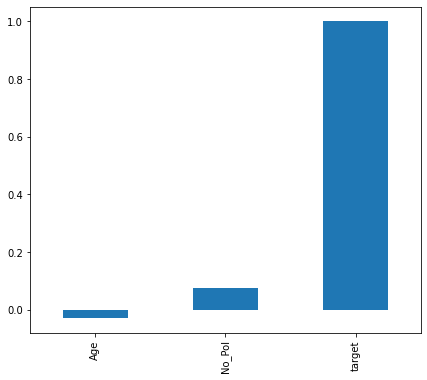

In [4]:
train.corr()['target'].sort_values().plot(kind='bar', figsize=(7, 6))

## Target Distribution

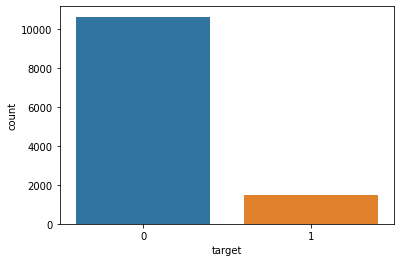

In [5]:
sns.countplot(train.target)

In [6]:
target = train.target
train = train.drop("target", axis = 1)

### Preprocessing/Feature Engineering

In [7]:
data=train.append(test)

In [8]:
data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     515
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              5376
Subject_Car_Colour        9967
Subject_Car_Make          3537
LGA_Name                  9258
State                     9276
ProductName                  0
dtype: int64

In [9]:
date_col = ['Policy Start Date','Policy End Date','First Transaction Date']
for feat in date_col:
    data[feat] = pd.to_datetime(data[feat])

In [10]:
# NUMBER OF DAYS BETWEEN POLICY END DATE AND START DATE
data['policy_span'] = (data['Policy End Date'] - data['Policy Start Date']).dt.days

In [11]:
data['policy_span'].describe() #There seem to be very odd values 11139days

count    17256.000000
mean       348.149861
std        182.659095
min         12.000000
25%        364.000000
50%        364.000000
75%        364.000000
max      11139.000000
Name: policy_span, dtype: float64

In [12]:
data['policy_span'].loc[data['policy_span'] > 5000] = 348  #Replace extreme values with mean

In [13]:
# One hot encoding of all categorical feature

gender_dummies = pd.get_dummies(data.Gender)
data = pd.concat([data,gender_dummies], axis=1)
data = data.drop("Gender", axis=1)

Car_Category_dummies = pd.get_dummies(data.Car_Category)
data = pd.concat([data,Car_Category_dummies], axis=1)
data = data.drop("Car_Category", axis=1)
  
Subject_Car_Colour_dummies = pd.get_dummies(data.Subject_Car_Colour)
data = pd.concat([data,Subject_Car_Colour_dummies], axis=1)
data = data.drop("Subject_Car_Colour", axis=1)
  
Subject_Car_Make_dummies = pd.get_dummies(data.Subject_Car_Make)
data = pd.concat([data,Subject_Car_Make_dummies], axis=1)
data = data.drop("Subject_Car_Make", axis=1)
  
LGA_Name_dummies = pd.get_dummies(data.LGA_Name)
data = pd.concat([data,LGA_Name_dummies], axis=1)
data = data.drop("LGA_Name", axis=1)
  
State_dummies = pd.get_dummies(data.State)
data = pd.concat([data,State_dummies], axis=1)
data = data.drop("State", axis=1)
  
ProductName_dummies = pd.get_dummies(data.ProductName)
data = pd.concat([data,ProductName_dummies], axis=1)
data = data.drop("ProductName", axis=1)
  
del data['ID']

In [14]:
data.shape

(17256, 542)

In [15]:
date_col = ['Policy Start Date','Policy End Date','First Transaction Date']

In [16]:
# Feature binning
from sklearn.preprocessing import KBinsDiscretizer
age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

data['Age_Bins'] =age_discretizer.fit_transform(data['Age'].values.reshape(-1,1)).astype(int)

In [17]:
# Extract date features
def extract_date_info(df,cols,):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.quarter
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
        df[feat +'_weekday'] = df[feat].dt.weekday
        df[feat +'_week'] = df[feat].dt.week
    df.drop(columns=date_col,axis=1,inplace=True)


extract_date_info(data,date_col)

In [18]:
data.head(2)

,Age,No_Pol,policy_span,Entity,Female,Joint Gender,Male,NO GENDER,NOT STATED,SEX,Bus,CAMRY CAR HIRE,JEEP,Mini Bus,Mini Van,Motorcycle,Pick Up,Pick Up > 3 Tons,Saloon,Sedan,Shape Of Vehicle Chasis,Station 4 Wheel,Tipper Truck,Truck,Van,Wagon,As Attached,Ash,B.Silver,Beige Mitalic,Black,Black & Orange,Black & White,Blue,Blue & Red,Blue Sky,Blue&White&Red,Brown,Burgundy,Champagne,...,Oyo,Oyo-East,Oyo-West,Port-Harcourt,QuaAn-Pan,Rivers,Udi-Agwu,Ughelli-North,Umuahia-South,Warri-Central,Warri-North,Warri-South,CVTP,Car Classic,Car Plus,Car Vintage,CarFlex,CarSafe,Customized Motor,Motor Cycle,Muuve,Age_Bins,Policy Start Date_year,Policy Start Date_day,Policy Start Date_month,Policy Start Date_quarter,Policy Start Date_weekday,Policy Start Date_week,Policy End Date_year,Policy End Date_day,Policy End Date_month,Policy End Date_quarter,Policy End Date_weekday,Policy End Date_week,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter,First Transaction Date_weekday,First Transaction Date_week
0,30,1,364,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,14,5,2,4,19,2,13,5,2,4,19,2,14,5,2,4,19
1,79,1,364,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,4,29,11,4,0,48,4,28,11,4,0,48,4,29,11,4,0,48


In [19]:
# rename duplicated columns if present (to prevent errors after one hot encoding)
cols=pd.Series(data.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
data.columns=cols

One hot encoding increased data dimension to over 500 features, Some irrelevant features had to be droped after observing feature importance for previous models. Most irrelvant features were from `LGA_Name`..
- This could have been done in a less error prone and more efficient way, but due to time constraint, we just copied straight from `data.columns`

In [20]:
cols_to_remove = ['Bauchi','Abakaliki','Argungu','ENUGU SOUTH','Asa','Aba North','Aba South','AREPO','ALAPERE','Badagry','Asaba','Awka South','AWOYAYA','Bekwara','Asari-Toru',
                  'Asokoro District','Awka','Ejigbo','Awka North','Egor','Calabar','Abeokuta North','Anthony Village','Akoka','Akinyele','Ajeromi-Ifelodun','Calabar Municipality',
                  'Bosso','BARIGA','Akuku Toru','Central Area, Abuja','Akure North','Agbor','Akure South','Ado-Odo/Ota','Ado-Ekiti','Akwa Ibom','Bonny','Chanchaga','Aboh-Mbaise',
                  'Anambra East','Biase','Aniocha South','Abeokuta South','Ankpa','Dopemu','Akoko North West','AKOWONJO','EMENE','Benue','EFFURUN','Lincoln','AKOKO-EDO','Red & Black',
                  'Dark Gray','Dark Green','Dark Grey','Dark Red','Gray & Gray','Gray & Silver','Light Blue','Light Gray','Orange','Purple','Red & Blue','D. Red','Red & White','Red & Yellow',
                  'Red Maroon','White & Blue','White & Red','White & Yellow','Yellow','Yellow & White','ABG','As Attached.1','Dark Blue','D. Gold','AJAO ESTATE','Tipper Truck','First Transaction Date_quarter',
                  'NO GENDER','SEX','CAMRY CAR HIRE','First Transaction Date_year','Mini Van','Pick Up','Pick Up > 3 Tons','Shape Of Vehicle Chasis','Station 4 Wheel','Van','Cream','Wagon',
                  'B.Silver','Beige Mitalic','Policy End Date_quarter','Black & Orange','Blue & Red','Blue Sky','Blue&White&Red','Burgundy','Champagne','Ashok Leyland','Astra','BRILLIANCE',
                  'Rols Royce','Eket','MG','MINI COOPER','Man','Motorcycle.1','Opel','Porsche','REXTON','Raston','Renault','Scania','Bajaj','Seat','Skoda','Subaru','Suzuki','Tata',
                  'Wrangler Jeep','Yamaha','ZOYTE',' IFAKO','AGBARA','Land Rover.','LIBERTY','KA','Jincheng','Black.1','Buik','CHANGAN','COMMANDER','Caddillac','Chrysler','DAF','Datsun',
                  'Dodge','FOTON','GAC','GMC','Geely','Grand Cherokee','Howo','Hummer','Infiniti','Innson','Isuzu','Jaguar','Jeep','Ekeremor','Ughelli-North','Ekiti','Ekiti South-West','Aba-North',
                  'Aba-South','Abia','Aboh-Mbaise.1','Abuja.1','Ado-Ekiti.1','Ado-Ota','Ajegunle-State','Ajeromi-Ifelodun.1','Akoko-West','Anambra-East','Aniocha-South','Asari-Toru.1','Awka-North',
                  'Awka-South','Bauchi.1','Bayelsa','Warri-North','Calabar-Municipality','Central-Abuja','Cross-River','ENUGU-SOUTH','Ebonyi','Edo','Ekiti-East.1','AJAO-ESTATE','ABULE-EGBA',
                  'kumbotso','Ukpoba','QuaAn Pan','RIVERS','Rogo','SANGO OTTA','SANGOTEDO','Shagamu','Somolu','Tai ','Udi Agwu','Udu','Ughelli North','Umuahia','Zaria ','Umuahia South','Uvwie',
                  'Uyo','VGC','Warri-South','Warri North','Warri South','Wuse 11','Yenagoa','Yorro','Zaria','Ekiti-West','Enugu-North','Esan-Central','Ondo','N-A','Nasarawa','Ndokwa-East','Ngor-Okpala.1',
                  'Nnewi-North','Nnewi-South','Nsit-Ubium','Obafemi-Owode.1','Ogba-Ndoni','Ogbmosho-South','Ogun-Waterside','Ondo-West','Kogi','Onitsha-North','Onitsha-South','Orile-Iganmu.1','Oshimili-North',
                  'Ovia-SouthWest','Owerri-North','Owerri-West','Oyo-East','Oyo-West','QuaAn-Pan','Umuahia-South','Kwara','Kebbi','Esan-West','Ile-Oluji.1','Essien-Udim','Ethiope-East','Gombe.1','Ibadan-East',
                  'Ibadan-North','Ibarapa-Central','Idemili-North','Idemili-south','Ife-North','Ijebu-East','Ijebu-North','Ilesha-East','Kano-Municipal','Ilesha-West','Ilorin-East','Ilorin-West',
                  'Imo','Isoko-North','Isoko-south','Jos-North','Jos-South','Kaduna.1','Kaduna-South','Kano.1','Palm Groove','Oyo West','Oyo East','Ilesha','Ife North','Ijebu East',
                  'Ijebu North','Ijora','Ikeja G.R.A','Ikenne','Ikot Ekpene','Ikotun','Ikwerre','Ile-Ife','Ile-Oluji','Ilesha East','Ifako-Agege','Ilesha West','Ilorin','Ilorin East','Ilorin West',
                  'Irepodun','Isoko North','Isoko south','Iwo','Jibia','Jos North','Jos South','Udi-Agwu','Idemili south','Kaduna South','Gombe','Ekiti-East','Ekwusigo','Eleme','Enugu North','Epe',
                  'Esan Central','Esan West','Essien Udim','Ethiope East','Garki','Garko','Goronyo','Idemili North','Hong','IBA','IBADAN NORTH EAST','IJAIYE','ISHAGA','Ibadan North','Ibadan North West',
                  'Ibadan South East','Ibadan South West','Ibarapa Central','Idanre','Kaduna','Kajola','Oyo','Onitsha North','Ogun Waterside','Oguta','Ohaukwu','Ojodu','Okpe','Okpokwu','Okrika','Olamabolo',
                  'Oluyole','Ondo West','Onitsha','Onitsha South','Ogbmosho South','Orile-Iganmu','Orolu','Orsu','Oshimili','Oshimili North','Osogbo','Oturkpo','Ovia SouthWest','Owerri North','Owerri West ','Oyi ',
                  'Ogbomoso','Ogba/Egbema/Ndoni','Kano','Ngor-Okpala','Kano Municipal','Karu','Katagum','Keffi','Kuje','LGA','Car Vintage','Lokoja','MAGBORO','Marina','Ndokwa East','Niger State',
                'Obalende','Njaba','Nnewi','Nnewi North','Nnewi South','Nsit Ubium','Nwangele','OBANIKORO','ONDO','ONIRU','OWODE','Obafemi-Owode','Ilasamaja']

In [21]:
len(cols_to_remove)

379

In [22]:
data = data.drop(columns=cols_to_remove, axis=1)

### Modelling

In [23]:
train=data.iloc[:12079,]
test= data.iloc[12079:,]
y = target

In [24]:
from lightgbm import LGBMClassifier

In [25]:
train.shape, test.shape

((12079, 179), (5177, 179))

- We performed 8 fold cross validation on the training data, predicting on the test set after each iteration.
- The mode(most occuring value) of all 8 predictions was then used to make final submission. More like Voting
- The most important hyperparameter used here is `scale_pos_weight`,Since we are dealing with an imbalanced dataset, by manually tuning this hyperparameter the model tries to balance the ratio of both positive and negative classes

In [26]:
from sklearn.model_selection import StratifiedKFold
predictions = []
fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42)
for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    classifier2=LGBMClassifier(learning_rate=0.1, n_estimators=800, scale_pos_weight = 5.0,)
    classifier2.fit(X_train, Y_train)
    preds=classifier2.predict(X_test)
    predictions.append(classifier2.predict(test))

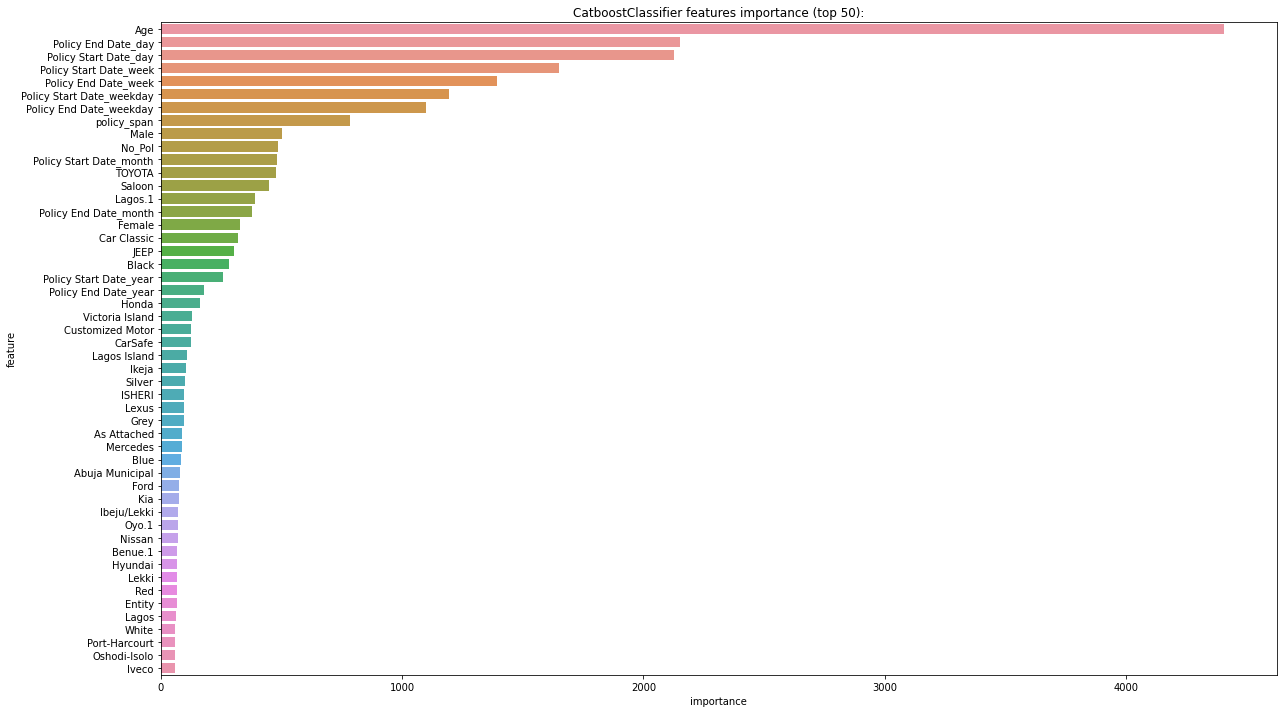

In [27]:
feature_importance_df = pd.DataFrame(classifier2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

In [28]:
predictions = pd.DataFrame(predictions)

In [29]:
predictions.T.head()

,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1


In [30]:
predictions = predictions.mode()

In [31]:
predictions = predictions.T
predictions

,0,1
0,1.0,NaN
1,1.0,NaN
2,0.0,NaN
3,0.0,NaN
4,1.0,NaN
...,...,...
5172,0.0,NaN
5173,0.0,NaN
5174,0.0,NaN
5175,1.0,NaN


In [32]:
sub = predictions[0]

In [33]:
sub.head()

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: 0, dtype: float64

In [34]:
sub_file = ss.copy()

In [35]:
sub_file.target = sub

In [36]:
sub_file.to_csv('confirm_score_reproducibility.csv',index=False)